In [1]:
import nbimporter
import dataset_class as StreetSign
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torch import nn
from torch.optim import SGD
from sklearn.metrics import accuracy_score
from os.path import join
import torch
import numpy as np
from PIL import Image
from os import path

import matplotlib.pyplot as plt

np.random.seed(1328)
torch.random.manual_seed(1328);

In [2]:
#resize normale
tran = transforms.Compose([StreetSign.Rescale(256),StreetSign.RandomCrop(32),StreetSign.ToTensor()])
#tran = None

datatrain = StreetSign.StreetSignDataset('DITS-full\DITS-full\DITS-detection\class\classes.csv','DITS-full\DITS-full\DITS-detection\class\image',tran)


In [3]:
#stamp try

sample = datatrain[230]
print(sample['image'].size())
print(sample['landmarks'])

torch.Size([3, 32, 32])
tensor([1.])


In [4]:
#resize normale
datatest = StreetSign.StreetSignDataset('DITS-full\DITS-full\DITS-detection\detection_test\day\classes.csv','DITS-full\DITS-full\DITS-detection\detection_test\day',tran)

In [5]:
#stamp try

sample = datatest[10]
print(sample['image'].size())
print(sample['landmarks'])

torch.Size([3, 32, 32])
tensor([1.])


In [6]:
class AverageValueMeter():
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.sum = 0
        self.num = 0
        
    def add(self, value, num):
        self.sum += value*num
        self.num += num
        
    def value(self):
        try :
            return self.sum/ self.num
        except :
            return None

In [7]:
def train_classifier(model, train_loader, test_loader, exp_name='experiment' ,
                     lr=0.01, epochs=10, momentum=0.99, logdir='logs'):
    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr, momentum=momentum)
    #meters
    loss_meter = AverageValueMeter()
    acc_meter = AverageValueMeter()
    #writer
    writer = SummaryWriter(join(logdir, exp_name))
    #device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    #definiamo un dizionario contenente i Loader di training e test
    loader = {
        'train' : train_loader,
        'test' : test_loader
    }
    #iniziaLizziamo iL global step
    global_step = 0
    for e in range(epochs):
        #iteriamo tra due modalità: train e test
        for mode in ['train' , 'test']:
            loss_meter.reset(); acc_meter.reset()
            model.train() if mode == 'train' else model.eval()
            with torch.set_grad_enabled(mode=='train'): #abiLitiamo i gradienti SOLO in training
                for i, batch in enumerate(loader[mode]):
                    x=batch[0].to(device) #"portiamoLi sul device corretto"
                    y=batch[1].to(device)
                    output = model(x)
                    
                    #aggiorniamo iL gLobaL_step
                    #conterrà iL numero di campioni visti durante iL training
                    n = x.shape[0] #numero di elementi nel batch
                    global_step += n
                    l = criterion(output, y)
                    
                    if mode=='train' :
                        l.backward()
                        optimizer.step( )
                        optimizer.zero_grad ( )
                    
                    acc = accuracy_score(y.to('cpu '),output.to(' cpu').max(1)[1])
                    loss_meter.add(l.item(), n)
                    acc_meter.add(acc,n)
                    
                    #Loggiamo i risultati iterazione per iterazione SOLO durante iL training
                    if mode=='train' :
                        writer.add_scalar( ' loss/train ' ,loss_meter.value(), global_step=global_step)
                        writer.add_scalar( 'accuracy/train' ,acc_meter.value(), global_step=global_step)            
                #una voLta finita L 'epoca (sia nel caso di training che test, Loggiamo Le stime finali)
                writer.add_scalar( 'loss/' + mode, loss_meter.value(), global_step=global_step)
                writer.add_scalar( 'accuracy/' + mode, acc_meter.value(), global_step=global_step)
        #conserviamo i pesi del model Lo aLLa fine di un ciclo di training e test
        torch. save(model.state_dict(), '%s-%d.pth'%(exp_name,e+1))
    return model

In [8]:
def test_classifier(model, loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    predictions, labels = [], []
    for batch in loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        output = model(x)
        preds = output.to('cpu').max(1)[1].numpy()
        labs = y.to('cpu').numpy()
        predictions.extend(list(preds))
        labels.extend(list(labs))
    return np.array(predictions), np.array(labels)

In [9]:
class LeNetColor(nn.Module):
    def __init__ (self):
        super(LeNetColor, self).__init__()
        #ridefiniamo iL modeLLo utilizzando i moduli sequentiaL.
        #ne definiamo due: un "feature extractor", che estrae Le feature maps
        #e un "classificatore" che implementa i LiveLLy FC
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 18, 5), #Input: 3 x 32 x 32. Ouput: 18 x 28 x 28
            nn.MaxPool2d(2), #Input: 18 x 28 x 28. Output: 18 x 14 x 14
            nn.ReLU(),
            nn.Conv2d(18, 28, 5), #lnput 18 x 14 x 14. Output: 28 x le x le
            nn.MaxPool2d(2), #Input 28 x le x le. Output: 28 x 5 x 5
            nn.ReLU()
        )    
            
        self.classifier = nn.Sequential(
            nn.Linear(700, 360), #rnput: 28 * 5 * 5
            nn.ReLU(),
            nn.Linear(360, 252),
            nn.ReLU(),
            nn.Linear(252, 100)
        )
        
    def forward(self,x):
        #AppLichiamo Le diverse trasformazioni in cascata
        x = self.feature_extractor(x)
        x = self.classifier(x.view(x.shape[0],-1))
        return x

In [13]:
datatrain_loader = DataLoader(datatrain, batch_size=1024, shuffle=True)
#cifar100_test_loader = DataLoader(cifar100_test, batch_size=1024, num_workers=2)
datatest_loader = DataLoader(datatest, batch_size=1024, shuffle=True)
#cifar100_test_loader = DataLoader(cifar100_test, batch_size=1024, num_workers=2)

In [14]:
loader = {
        'train' : datatrain_loader,
        'test' : datatest_loader
    }
x = loader['train']
print(x)

Feature batch shape: image
Labels batch shape: landmarks


TypeError: Image data of dtype <U1 cannot be converted to float

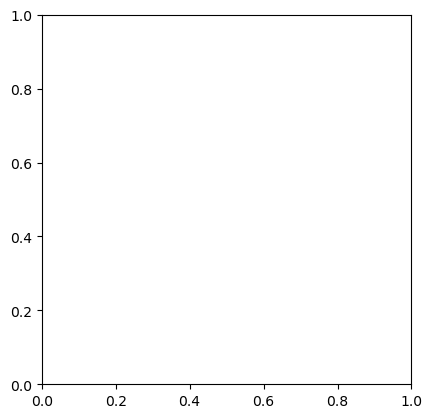

In [15]:
# Display image and label.
train_features, train_labels = next(iter(datatrain_loader))
print(f"Feature batch shape: {train_features}")
print(f"Labels batch shape: {train_labels}")
img = train_features[0]
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [16]:
lenet_datatrain = LeNetColor()
lenet_datatrain = train_classifier(lenet_datatrain, datatrain_loader, datatest_loader, \
                                 'lenet_dataset', epochs=1)

KeyError: 0

In [ ]:
lenet_data_test_predictions, data_labels_test = test_classifier(lenet_datatrain,
                                                                datatest_loader)
print("Accuracy LeNetColor su CIFAR-100: %0.2f" % \
      accuracy_score(data_labels_test,lenet_data_test_predictions))